## Pre-processing CellRanger outputs (single sample)

This notebook demonstrates the pipeline for processing scRNA-seq data, covering metric computation, normalization, clustering, cell type prediction, and the identification/removal of doublets and low-quality clusters. The final output is pre-processed, annotated scRNA-seq data.

In [1]:
import sys
path = '/home/vas744/Analysis/Python/Packages/PIASO'
sys.path.append(path)
path = '/home/vas744/Analysis/Python/Packages/COSG'
sys.path.append(path)
import piaso
import cosg

/home/vas744/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import logging
from matplotlib import rcParams
from sklearn.preprocessing import StandardScaler
import warnings

# To modify the default figure size, use rcParams.
rcParams['figure.figsize'] = 4, 4
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "Arial"
sc.settings.verbosity = 3
sc.logging.print_header()
sc.set_figure_params(dpi=80,dpi_save=300, color_map='viridis',facecolor='white')

scanpy==1.10.3 anndata==0.10.8 umap==0.5.7 numpy==1.26.4 scipy==1.13.0 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.5 louvain==0.8.2 pynndescent==0.5.13


In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)

### Load the data

The dataset used in this tutorial was obtained from: https://www.10xgenomics.com/datasets/10k-Mouse-Brain-CNIK-3p-gemx

Download the required dataset from Google Drive: https://drive.google.com/file/d/1nsaOC-__jUjXUjGqaUMaGBT2LWyu_L5_/view?usp=drive_link

In [4]:
!/home/vas744/Software/gdrive files download --overwrite --destination /n/scratch/users/v/vas744/Data/Public/PIASO 1nsaOC-__jUjXUjGqaUMaGBT2LWyu_L5_

Successfully downloaded 10k_Mouse_Brain_CNIK_3p_gemx_10k_Mouse_Brain_CNIK_3p_gemx_count_sample_filtered_feature_bc_matrix.h5


In [5]:
data_path = "/n/scratch/users/v/vas744/Data/Public/PIASO/10k_Mouse_Brain_CNIK_3p_gemx_10k_Mouse_Brain_CNIK_3p_gemx_count_sample_filtered_feature_bc_matrix.h5"

adata=sc.read_10x_h5(data_path)

reading /n/scratch/users/v/vas744/Data/Public/PIASO/10k_Mouse_Brain_CNIK_3p_gemx_10k_Mouse_Brain_CNIK_3p_gemx_count_sample_filtered_feature_bc_matrix.h5
 (0:00:02)


/home/vas744/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/vas744/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
adata

AnnData object with n_obs × n_vars = 11357 × 33696
    var: 'gene_ids', 'feature_types', 'genome'

In [7]:
adata.layers['raw']=adata.X.copy()

In [8]:
adata.var_names_make_unique()

This dataset contains a single sample, but we will add a Sample column to adata.obs and assign a sample name to facilitate downstream analysis.

In [9]:
adata.obs['Sample'] = 'MouseBrain3primeV4'

Next, we filter out cells with fewer than 200 detected genes.

In [10]:
sc.pp.filter_cells(adata, min_genes=200)

We identify mitochondrial and ribosomal protein genes and compute their proportion in each cell’s total read count. A high proportion of these reads often indicates low-quality cells.

In [11]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [12]:
ribo_cells = adata.var_names.str.startswith('Rps','Rpl')
adata.obs['pct_counts_ribo'] = np.ravel(100*np.sum(adata[:, ribo_cells].X, axis = 1) / np.sum(adata.X, axis = 1))

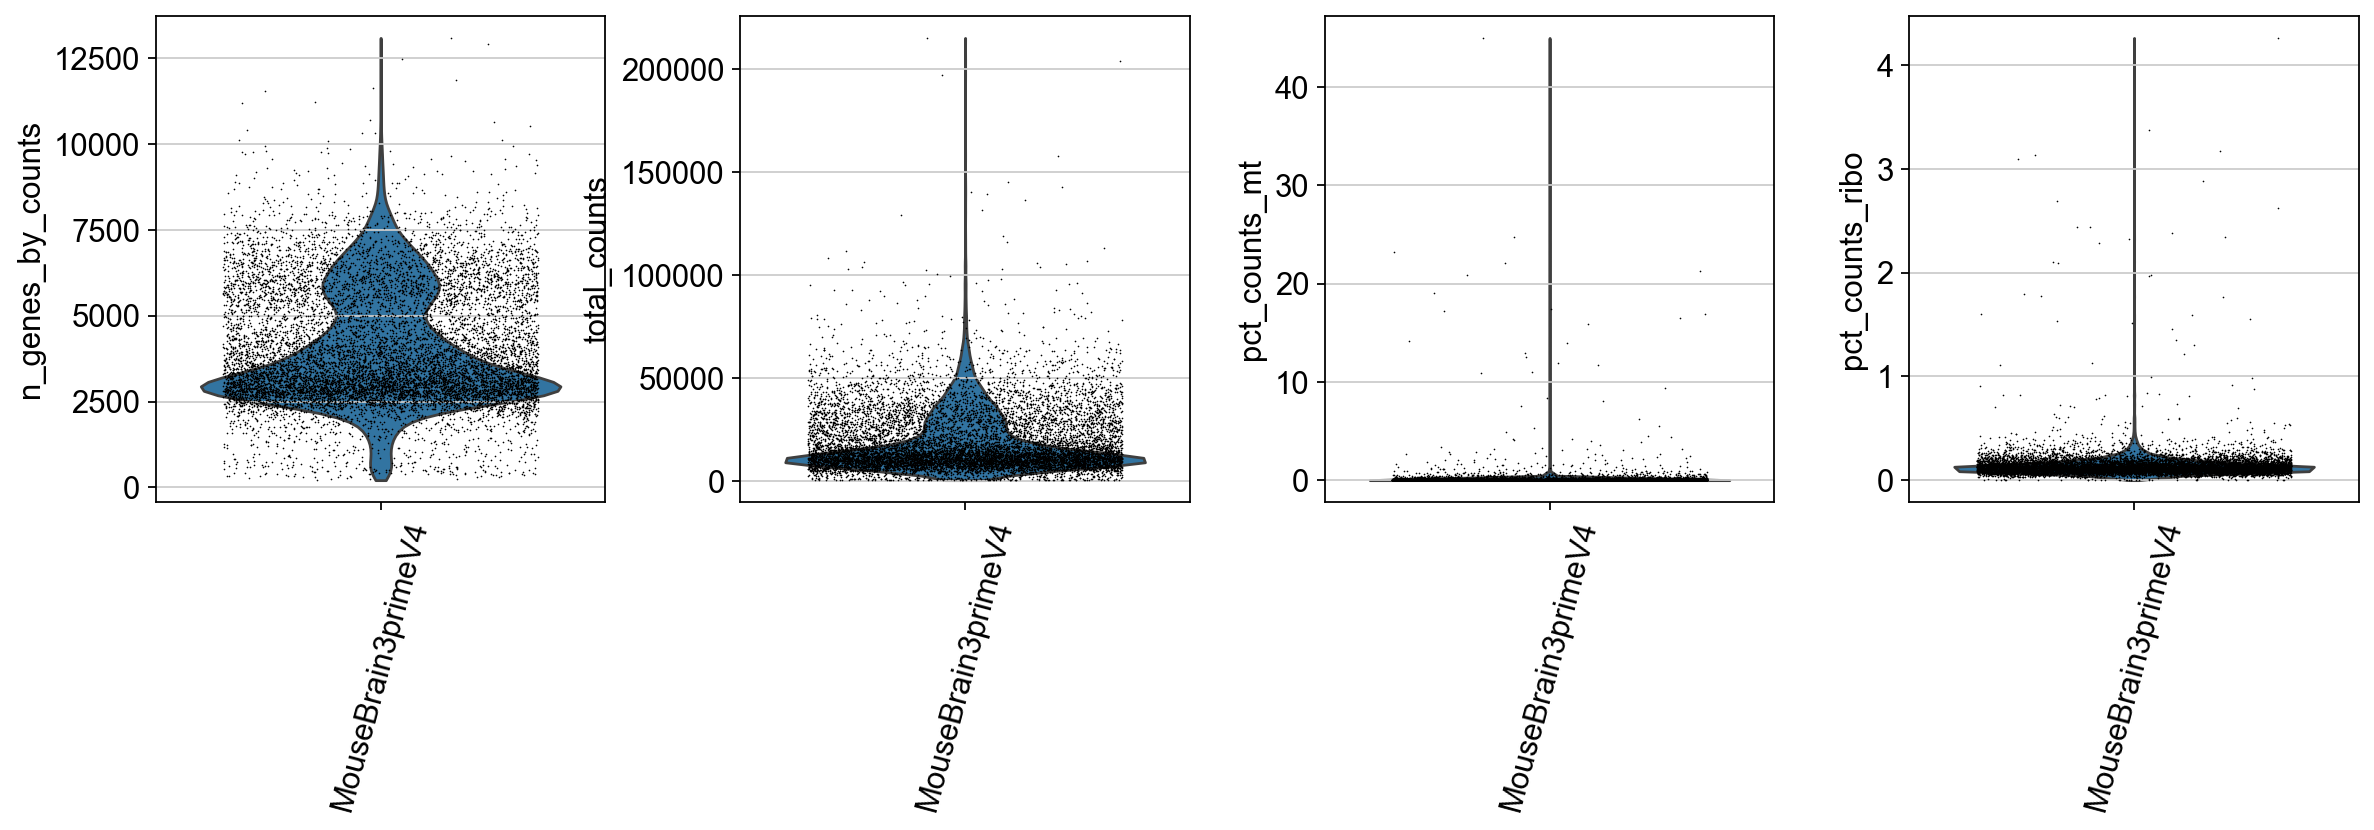

In [13]:
sc.pl.violin(adata,
             ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             groupby='Sample',
             rotation=75,
             jitter=0.35,
             multi_panel=True,
             size = 0.75)

### Doublet prediction

Next, we compute the Scrublet score to identify and predict potential doublets.

In [14]:
experiments=np.unique(adata.obs['Sample'])
adata.obs['scrublet_score']=np.repeat(0,adata.n_obs)
adata.obs['predicted_doublets']=np.repeat(False,adata.n_obs)

In [15]:
import scrublet as scr

for experiment in experiments:
    print(experiment)
    adatai=adata[adata.obs['Sample']==experiment]

    scrub = scr.Scrublet(adatai.X.todense(),random_state=10)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    
    adata.obs['predicted_doublets'][adatai.obs_names]=predicted_doublets
    
    adata.obs['scrublet_score'][adatai.obs_names]=doublet_scores    

MouseBrain3primeV4
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.30
Detected doublet rate = 5.8%
Estimated detectable doublet fraction = 62.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.2%
Elapsed time: 70.9 seconds


/tmp/ipykernel_16745/2312138584.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['predicted_doublets'][adatai.obs_names]=predicted_doublets
/tmp/ipykernel_16745/2312138584.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['scrublet_score'][adatai.obs_names]=doublet_scores


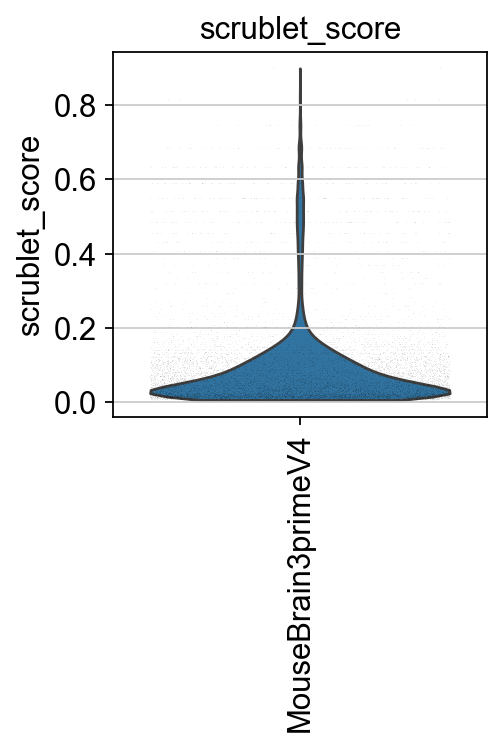

In [16]:
piaso.pl.plot_features_violin(adata,
                              ['scrublet_score'],
                              groupby='Sample',
                              width_single=3,
                              height_single=3)

In [17]:
tmp=np.repeat(False, adata.n_obs)
tmp[adata.obs['predicted_doublets'].values==True]=True
adata.obs['predicted_doublets']=tmp

In [18]:
print(f"# of cells with scrublet score >= 0.2: {np.sum(adata.obs['scrublet_score']>=0.2)} \n# of predicted doublets: {np.sum(adata.obs['predicted_doublets'])}")

# of cells with scrublet score >= 0.2: 874 
# of predicted doublets: 657


### Normalization

In [19]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata.layers['log1p']=adata.X.copy()

normalizing counts per cell
    finished (0:00:00)


### INFOG normalization

We use PIASO's infog to normalize the data and identify a highly variable set of genes.

In [20]:
%%time
piaso.tl.infog(adata,
               layer='raw',
               n_top_genes=3000,)

The normalized data is saved as `infog` in `adata.layers`.
The highly variable genes are saved as `highly_variable` in `adata.var`.
Finished INFOG normalization.
CPU times: user 3.74 s, sys: 3.86 s, total: 7.6 s
Wall time: 7.59 s


### SVD Dimensionality reduction and visualization

In [21]:
piaso.tl.runSVD(adata,
                use_highly_variable=True,
                n_components=50,
                random_state=10,
                key_added='X_svd',
                layer='infog')

In [22]:
%%time
sc.pp.neighbors(adata,
                use_rep='X_svd',
                n_neighbors=15,
                random_state=10,
                knn=True,
                method="umap")

sc.tl.umap(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:36)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:14)
CPU times: user 1min 15s, sys: 267 ms, total: 1min 16s
Wall time: 51.2 s


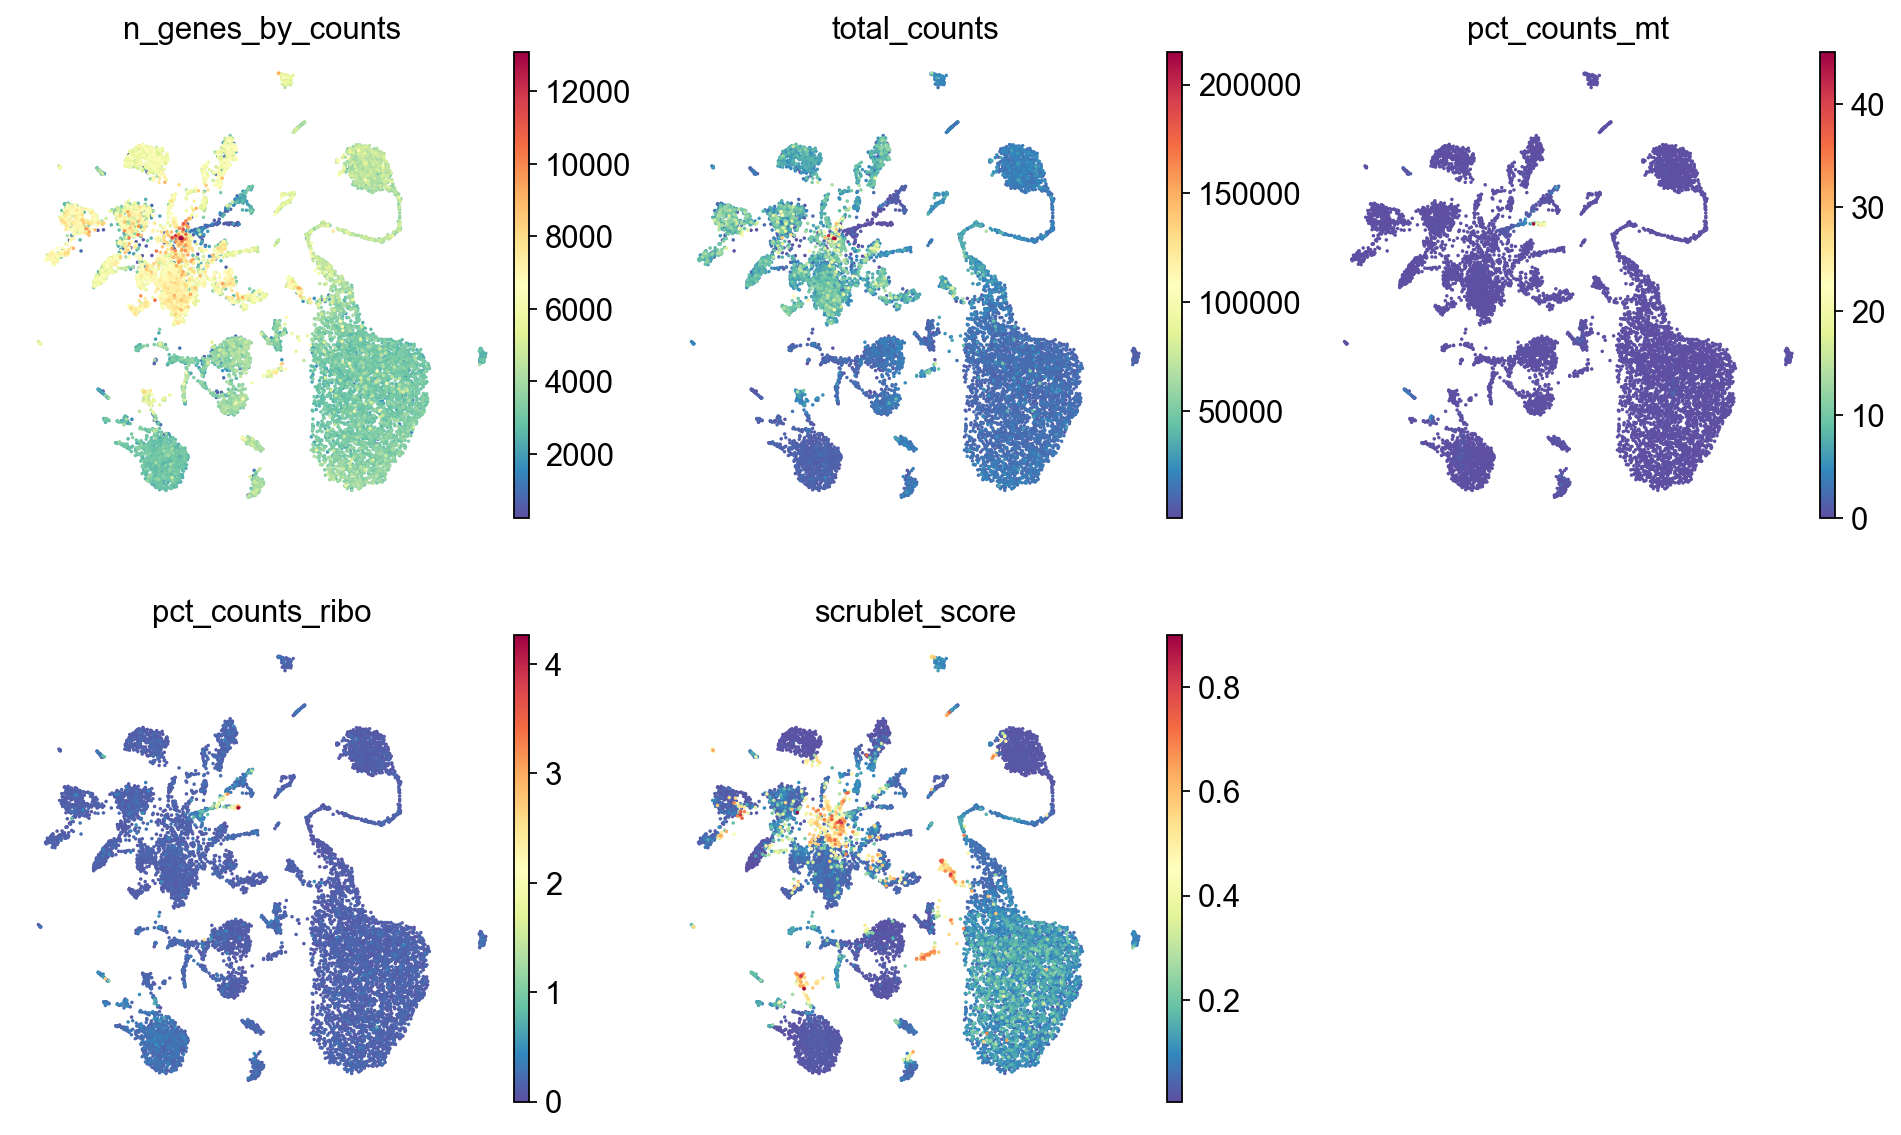

In [23]:
sc.pl.umap(adata,
           color=['n_genes_by_counts', 'total_counts','pct_counts_mt','pct_counts_ribo', 'scrublet_score'],
           cmap='Spectral_r',
           palette=piaso.pl.color.d_color1,
           ncols=3,
           size=10,
           frameon=False)

### Leiden clustering

In [24]:
%%time
sc.tl.leiden(adata,resolution=0.5,key_added='Leiden')

running Leiden clustering
    finished: found 32 clusters and added
    'Leiden', the cluster labels (adata.obs, categorical) (0:00:00)
CPU times: user 877 ms, sys: 23 ms, total: 900 ms
Wall time: 894 ms


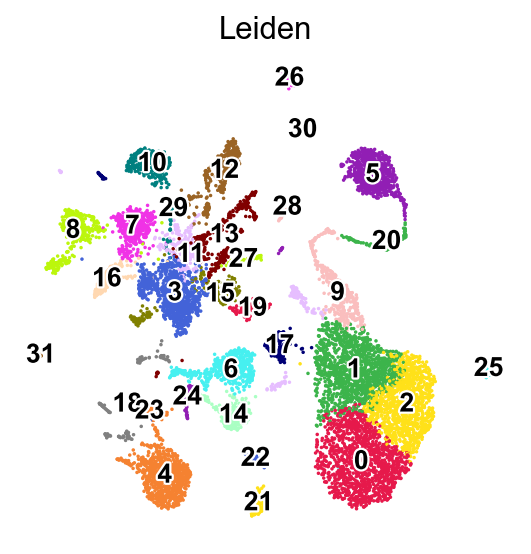

In [25]:
sc.pl.umap(adata,
           color=['Leiden'],
           palette=piaso.pl.color.d_color1,
           legend_fontsize=12,
           legend_fontoutline=2,
           legend_loc='on data',
           ncols=1,
           size=10,
           frameon=False)

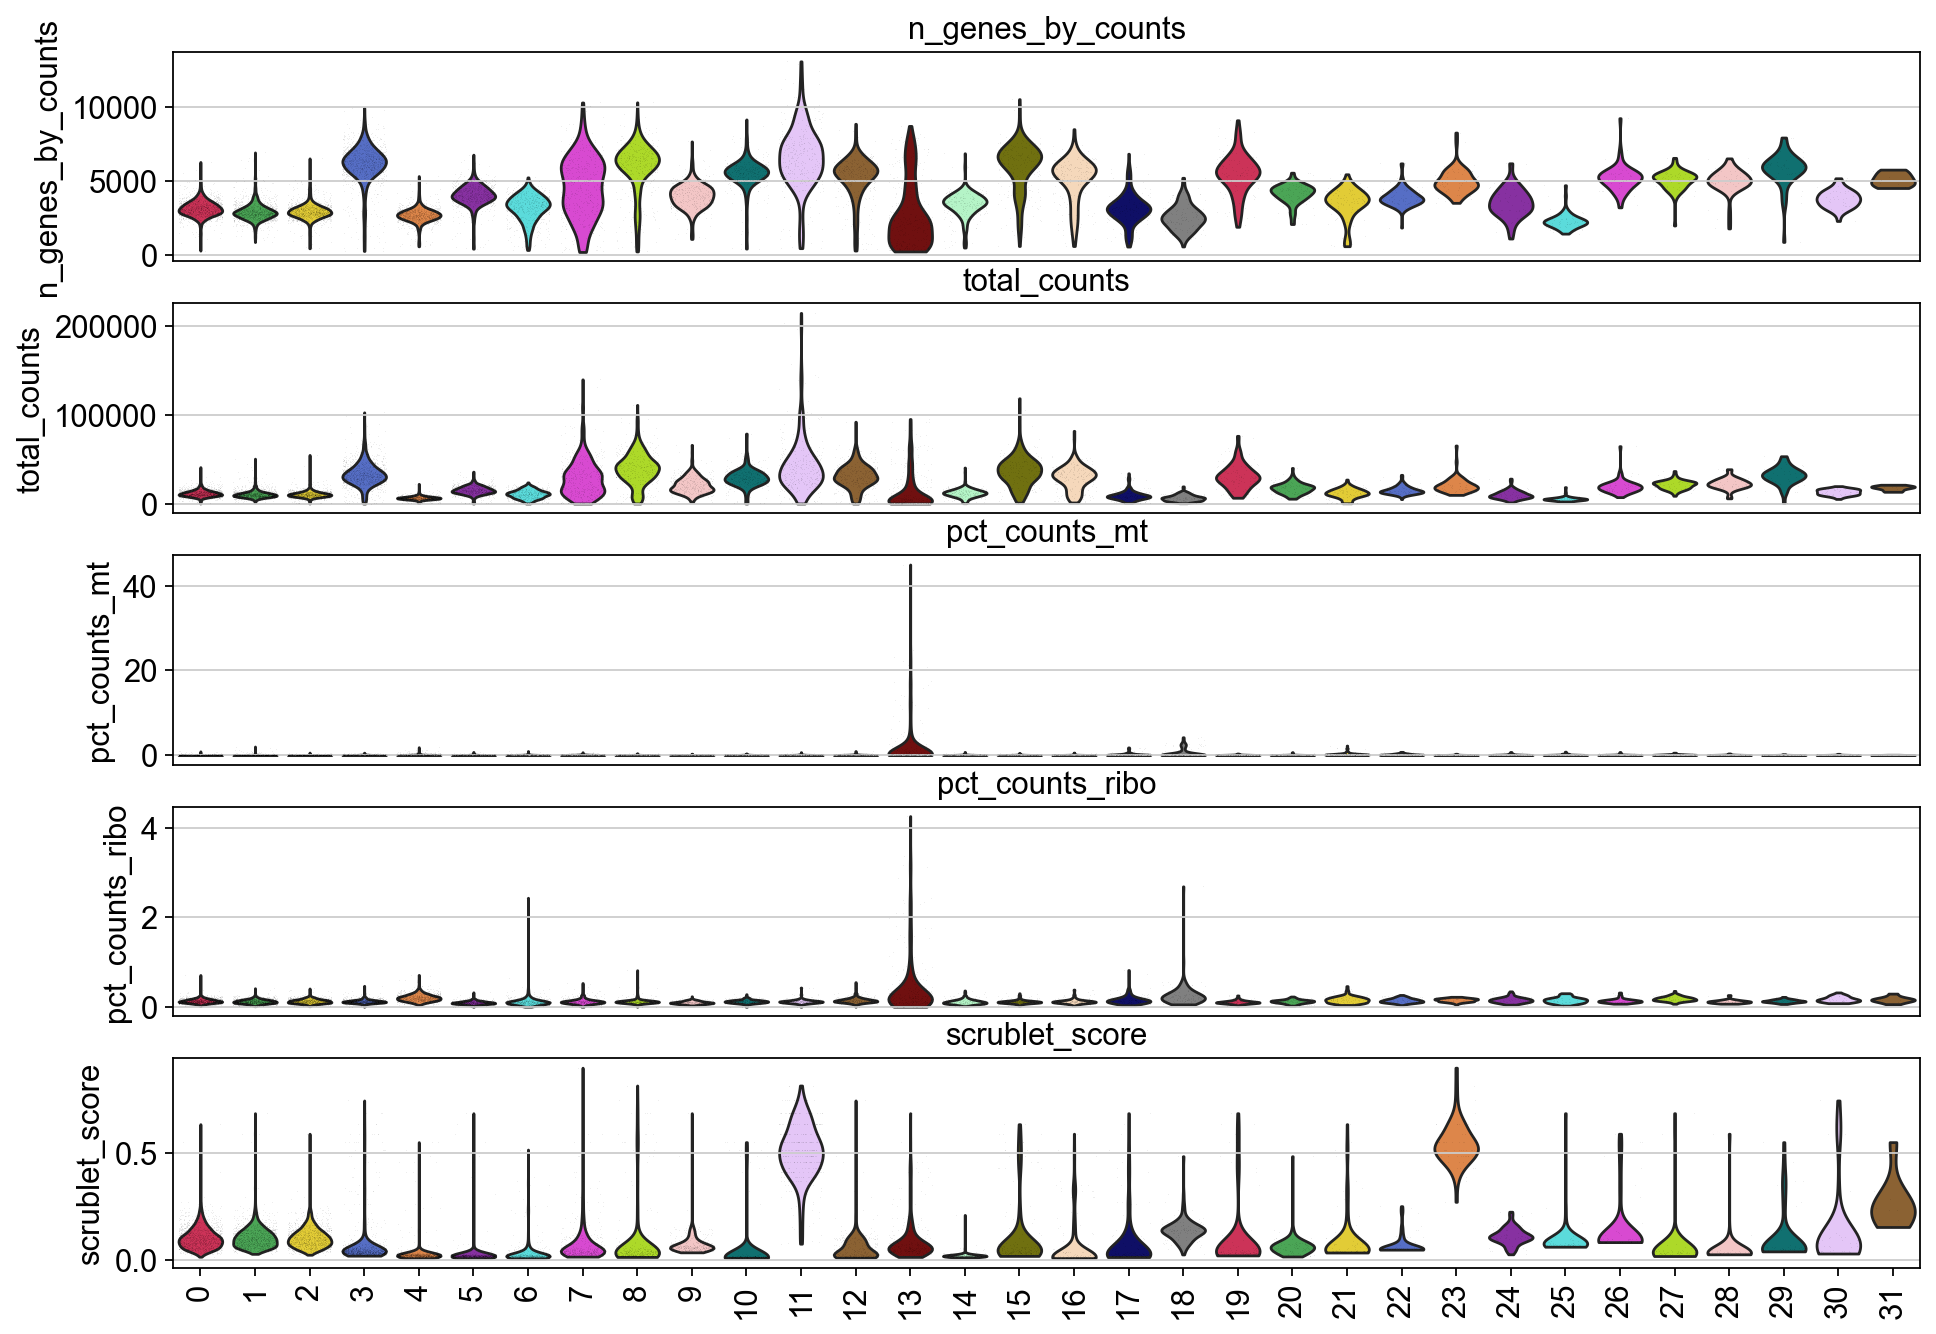

In [26]:
piaso.pl.plot_features_violin(adata,
                              ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'scrublet_score'],
                              groupby='Leiden')

#### Identify marker genes with COSG

In [27]:
%%time
n_gene=30
cosg.cosg(adata,
          key_added='cosg',
          use_raw=False,
          layer='log1p',
          mu=100,
          expressed_pct=0.1,
          remove_lowly_expressed=True,
          n_genes_user=100,
          groupby='Leiden')

CPU times: user 3.01 s, sys: 825 ms, total: 3.83 s
Wall time: 3.83 s


We can use a dendrogram dot plot to visualize the expression of the top three marker genes of each Leiden cluster.

Storing dendrogram info using `.uns['dendrogram_Leiden']`


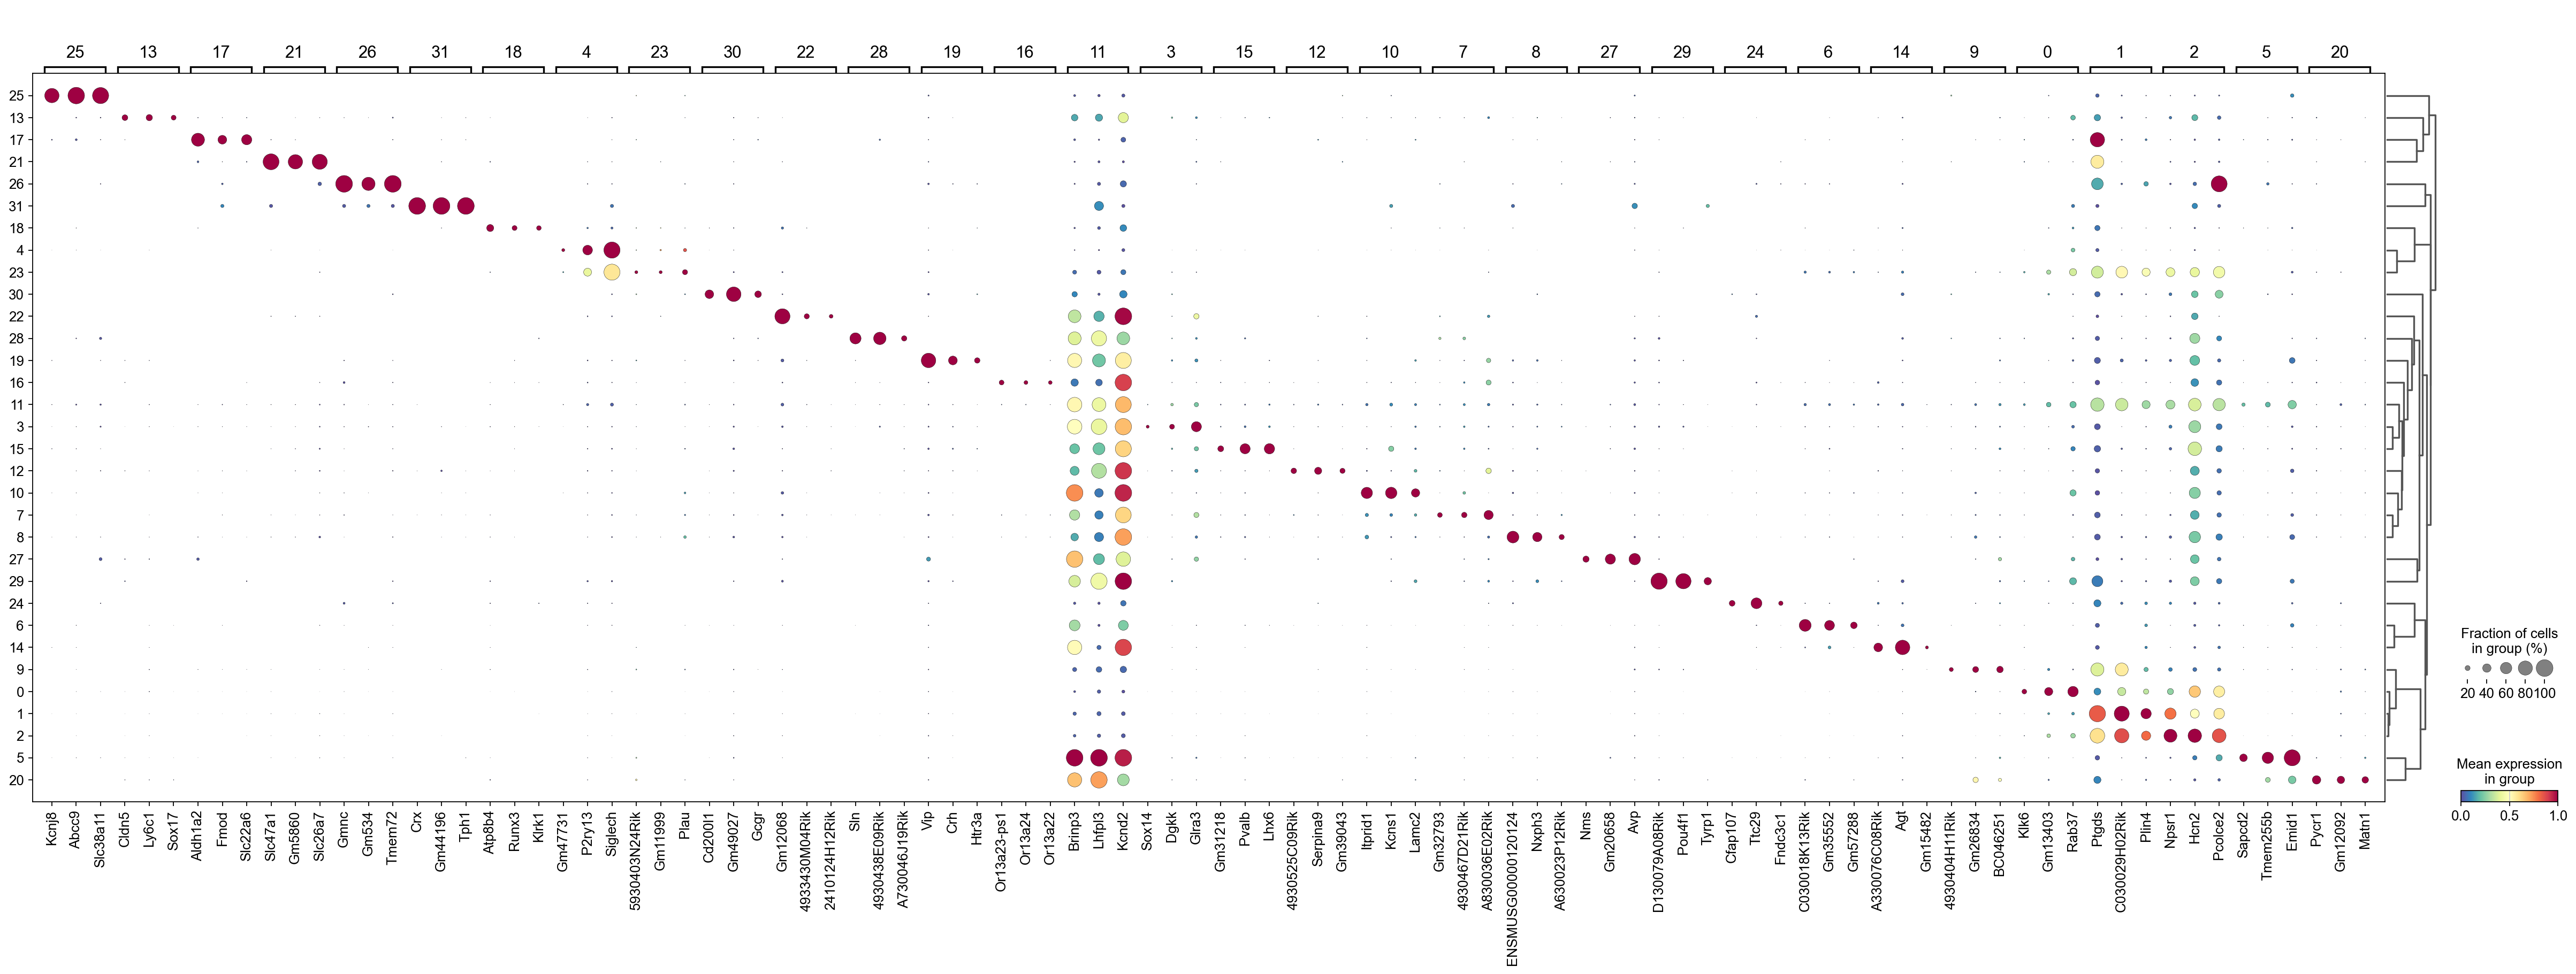

In [28]:
sc.tl.dendrogram(adata,groupby='Leiden',use_rep='X_svd')
df_tmp=pd.DataFrame(adata.uns['cosg']['names'][:3,]).T
df_tmp=df_tmp.reindex(adata.uns['dendrogram_'+'Leiden']['categories_ordered'])
marker_genes_list={idx: list(row.values) for idx, row in df_tmp.iterrows()}
marker_genes_list = {k: v for k, v in marker_genes_list.items() if not any(isinstance(x, float) for x in v)}

sc.pl.dotplot(adata,
              marker_genes_list,
              groupby='Leiden',
              layer='log1p',
              dendrogram=True,
              swap_axes=False,
              standard_scale='var',
              cmap='Spectral_r')

Another way to visualize the expression of the top three marker genes from each Leiden cluster is by using COSG's plotMarkerDendrogram method to create a circular dendrogram.

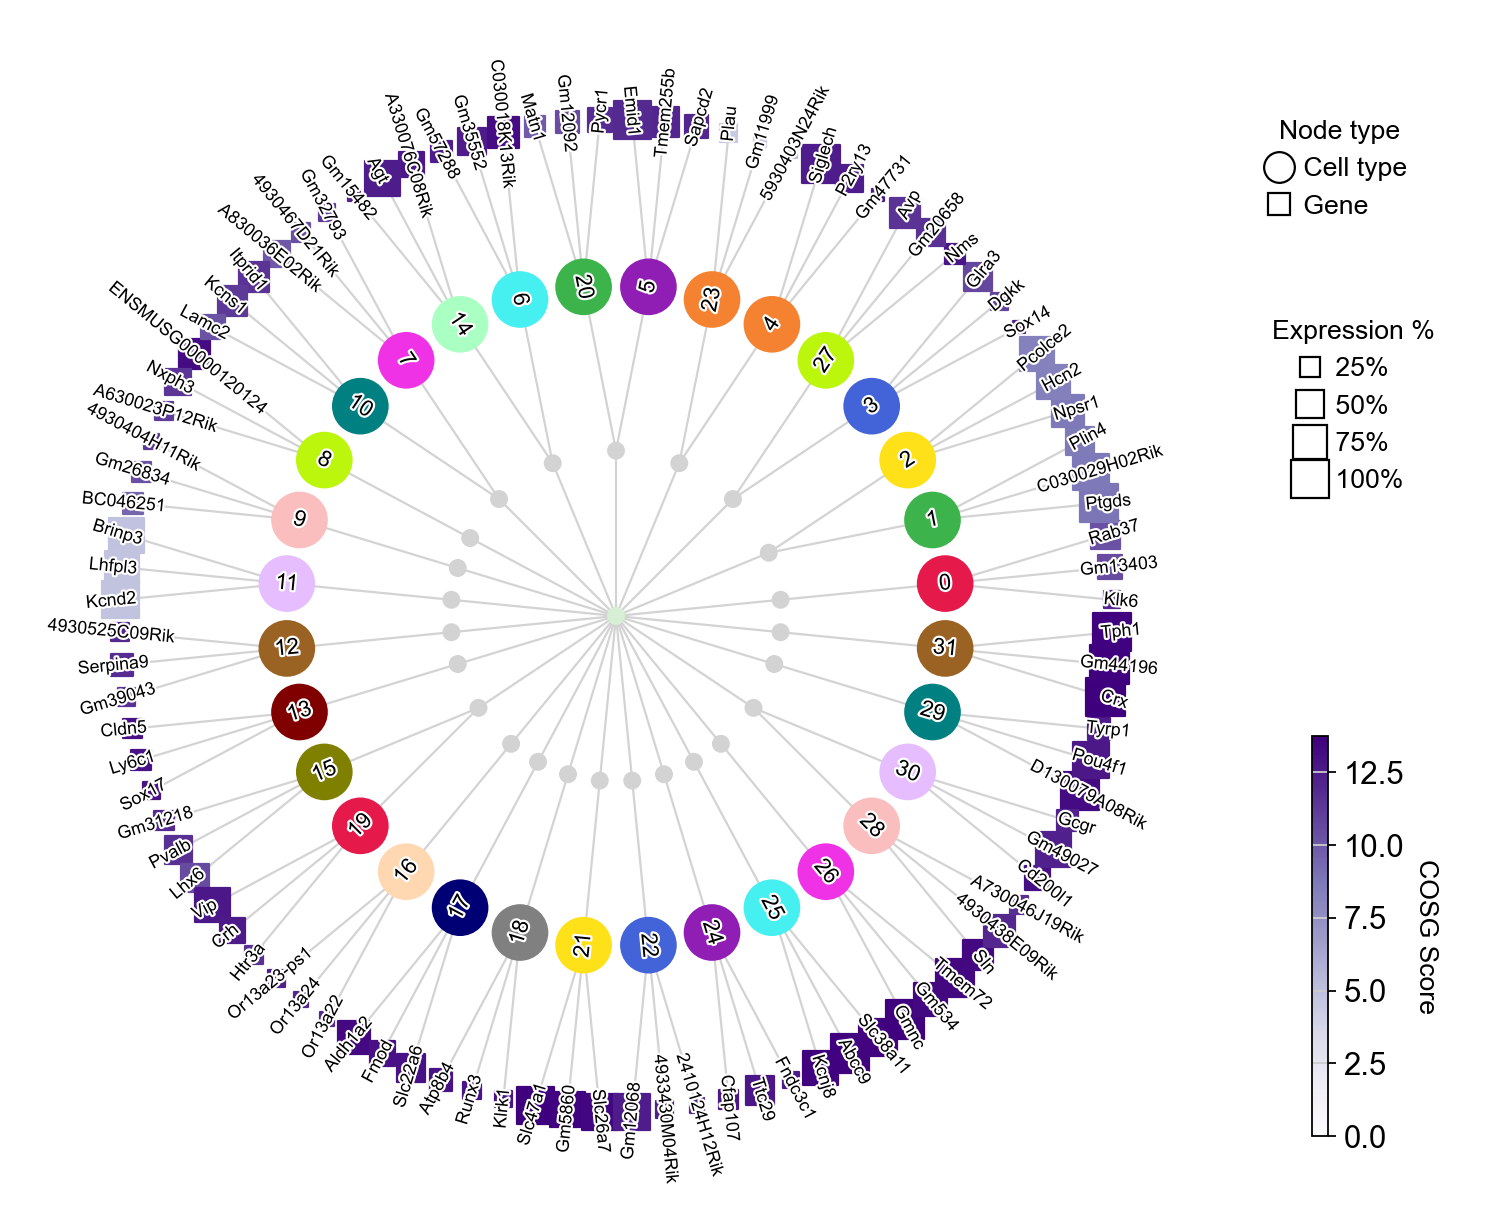

In [29]:
cosg.plotMarkerDendrogram(
     adata,
     group_by="Leiden",
     use_rep="X_svd",
     calculate_dendrogram_on_cosg_scores=True,
     top_n_genes=3,
     radius_step=4.5,
     cmap="Purples",
     gene_label_offset=0.25,
     gene_label_color="black",
     linkage_method="ward",
     distance_metric="correlation",
     hierarchy_merge_scale=0,
     collapse_scale=0.5,
     add_cluster_node_for_single_node_cluster=True,
     palette=None,
     figure_size= (10, 10),
     colorbar_width=0.01,
     gene_color_min=0,
     gene_color_max=None,
     show_figure=True,
)

### Marker genes of an individual cluster

We can use dotplots and UMAPs to visualize the expression of the top marker genes in a selected cluster, which can be used to evaluate cluster quality.

In [30]:
marker_gene=pd.DataFrame(adata.uns['cosg']['names'])

In [31]:
cluster_check='8'
marker_gene[cluster_check].values

array(['ENSMUSG00000120124', 'Nxph3', 'A630023P12Rik', 'Trpv6', 'Gm27040',
       'Chrna5', 'Nlrp6', 'Fezf2', '5330416C01Rik', 'Tbata',
       '4930551E15Rik', 'Hs3st4', 'Krt80', 'Abi3bp', 'Gm35161', 'Gm15942',
       'B4galnt3', 'Gm17171', 'Rxfp1', 'Htr1f', 'Cwh43', 'Tmem178',
       'Prss12', 'Gm49422', 'Prss35', 'Serinc2', 'Gm11762', 'Gm13335',
       'Gm36736', 'Gm31308', 'Rprm', 'Myl4', 'Hs3st2', 'Ipcef1', 'Hmga2',
       'Ccn4', 'Galnt9', 'Hcrtr2', 'Col5a1', 'Sdk2', 'Nptx1', 'Sel1l3',
       'Slc16a10', 'Gm13391', 'Sv2b', 'Ephb6', 'Rspo2', 'A830018L16Rik',
       'Scube2', 'Trbc2', 'Mirt1', 'Pcsk5', 'Adgra1', 'Gm15270',
       'Gm27234', 'Cpa6', 'Gm20878', 'Kcnmb4', 'Cdh18', 'Diras2',
       'Hcrtr1', 'Khdrbs3', 'Gm5468', 'Zmiz1os1', 'Etl4', 'Rgsl1',
       'Serpinb8', 'Gm17167', 'Gm9899', 'Garnl3', 'Gm12394', 'Vwc2l',
       'Ptpru', 'Slc17a7', 'Ano3', 'Zdhhc23', 'Tbr1', 'Grik3', 'Gm2824',
       'Pamr1', 'Gm42056', 'Ccl27a', 'Kcnmb4os2', 'Col24a1', 'Gm32679',
       'Sigmar1', 

The dot plot below displays the expression of the top marker genes from cluster 8 across all clusters. For cluster 8 to be considered high quality, its top marker genes should be primarily specific to cluster 8, showing little to no expression in other clusters.

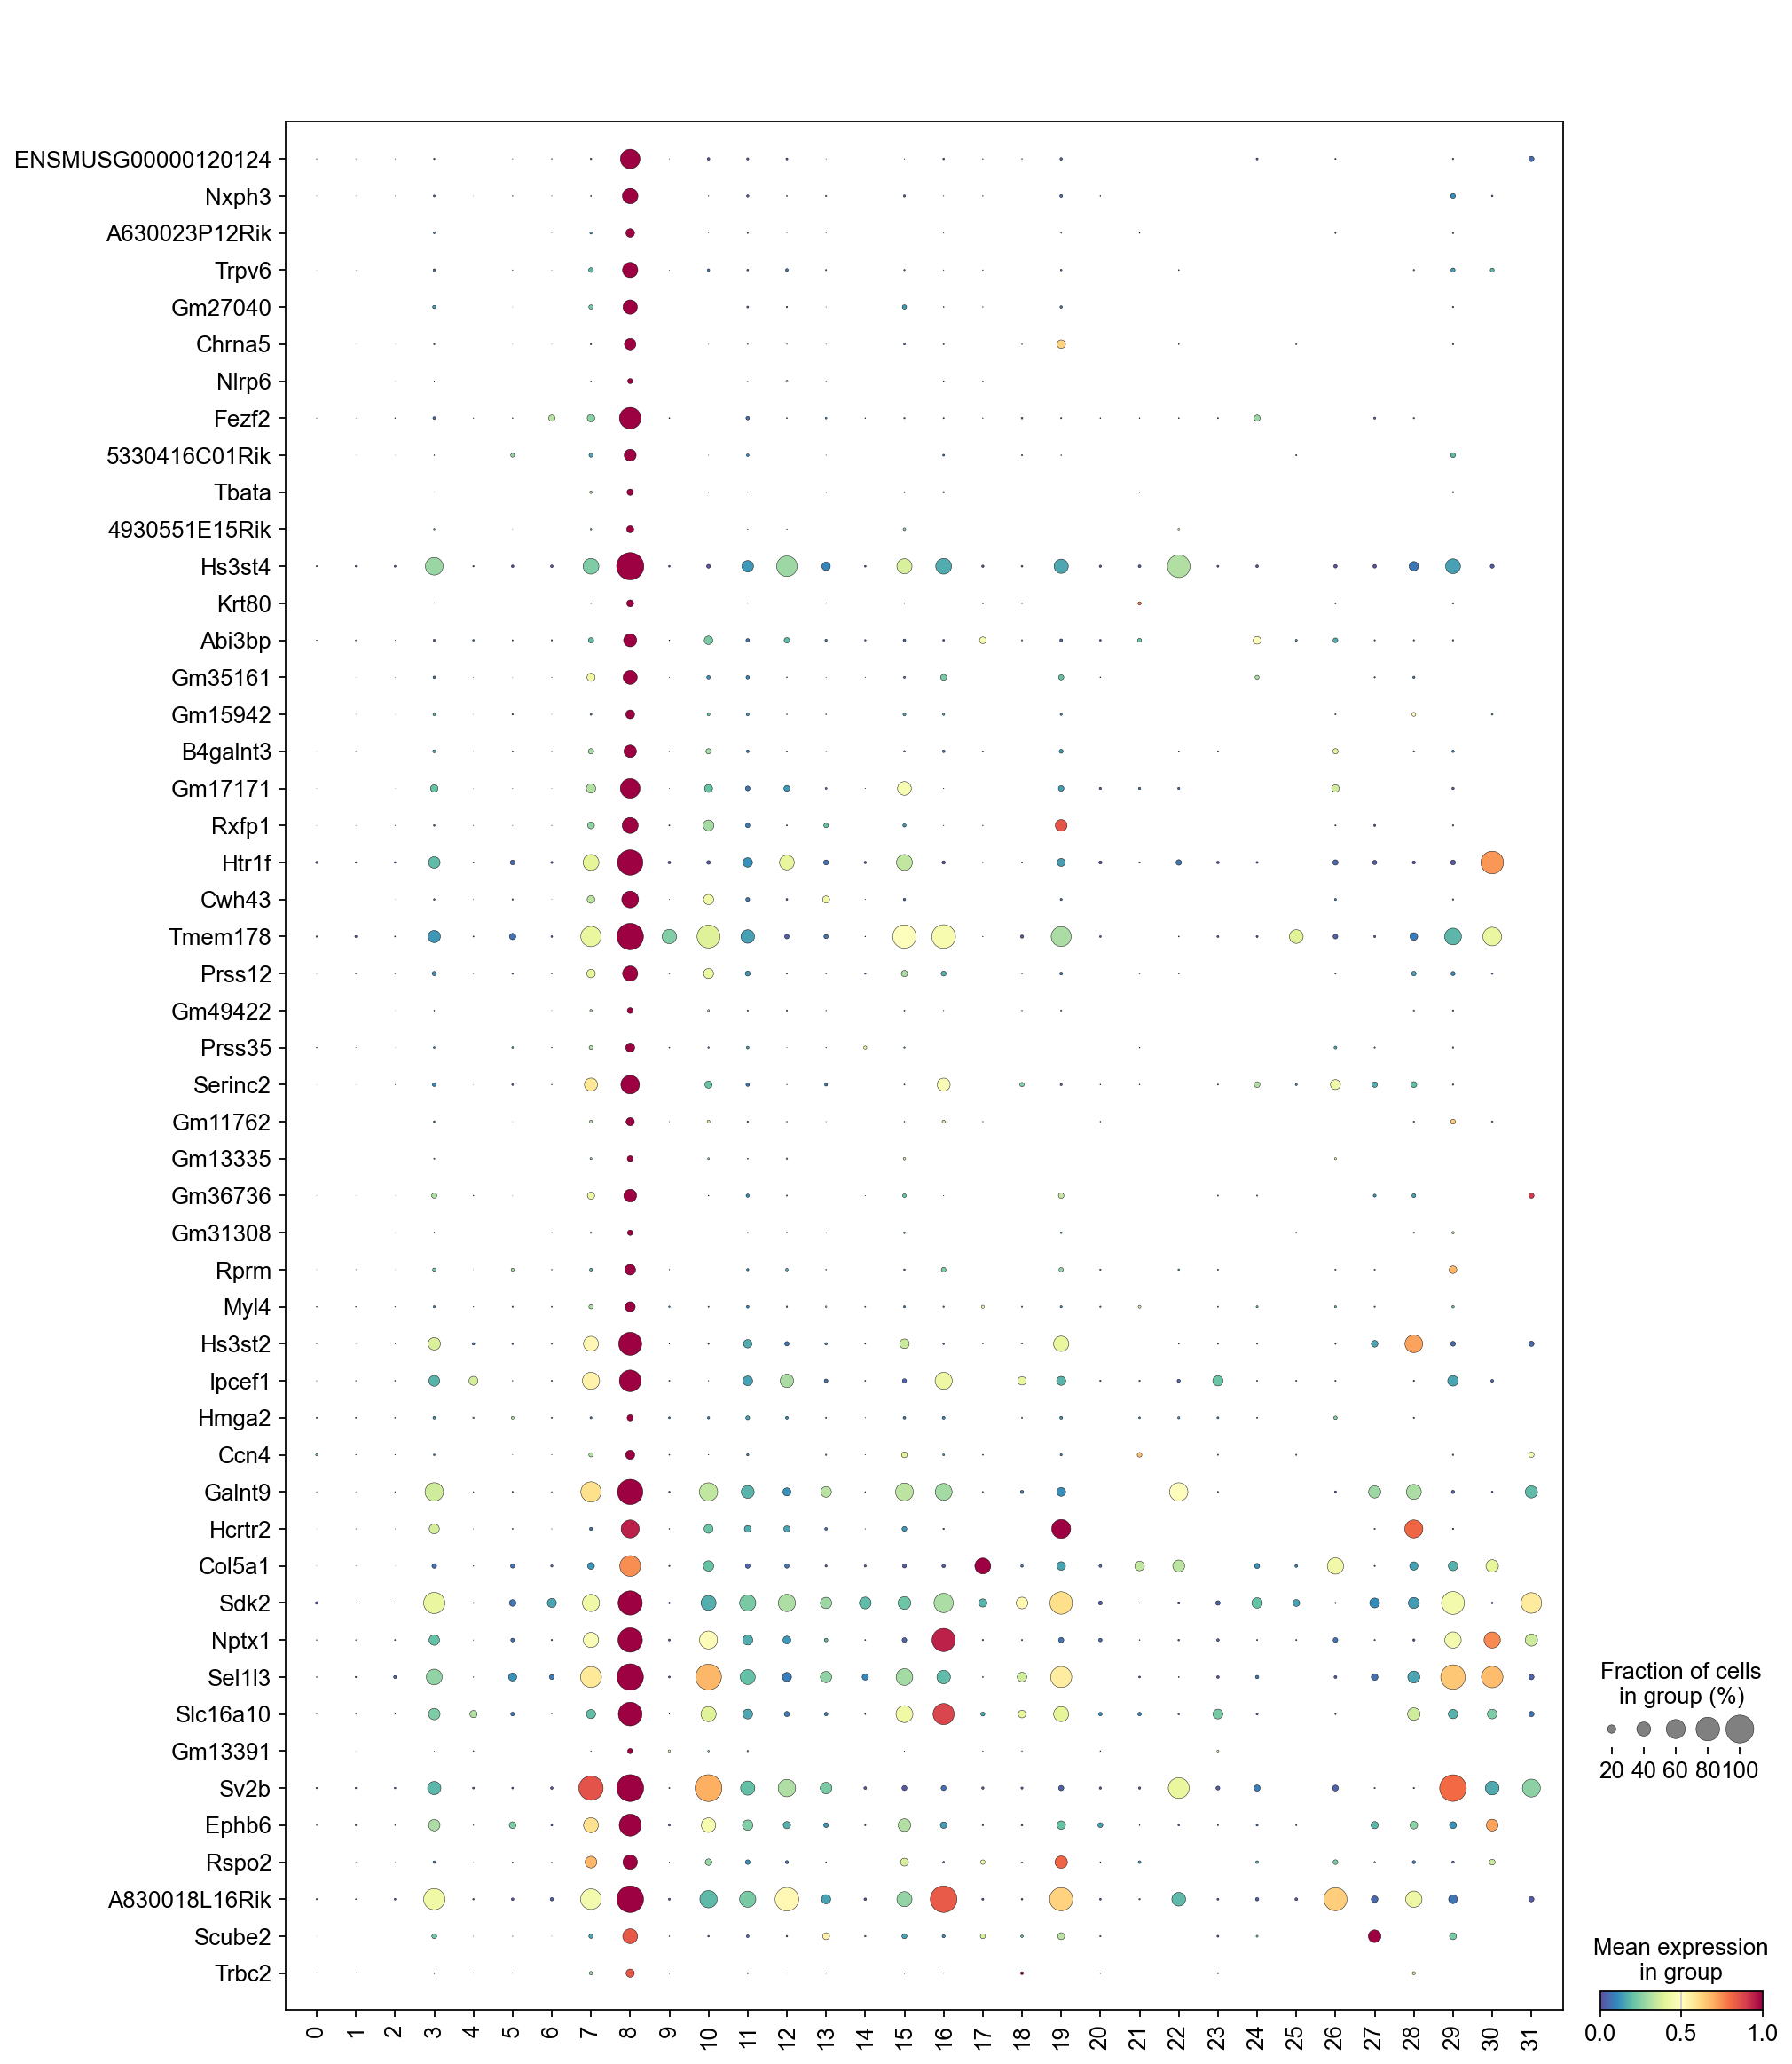

In [32]:
sc.pl.dotplot(adata,
              marker_gene[cluster_check].values[:50],
              groupby='Leiden',              
              dendrogram=False,
              swap_axes=True,
              standard_scale='var',
              cmap='Spectral_r')

We can visualize the expression of the top 12 genes from cluster 8 on UMAPs to assess whether their expression is specific to the cluster 8 region. This involves comparing the location of cluster 8 on the Leiden cluster UMAP with the gene expression UMAPs. In a high-quality cluster, marker gene expression should be predominantly localized to the cluster 8 area.

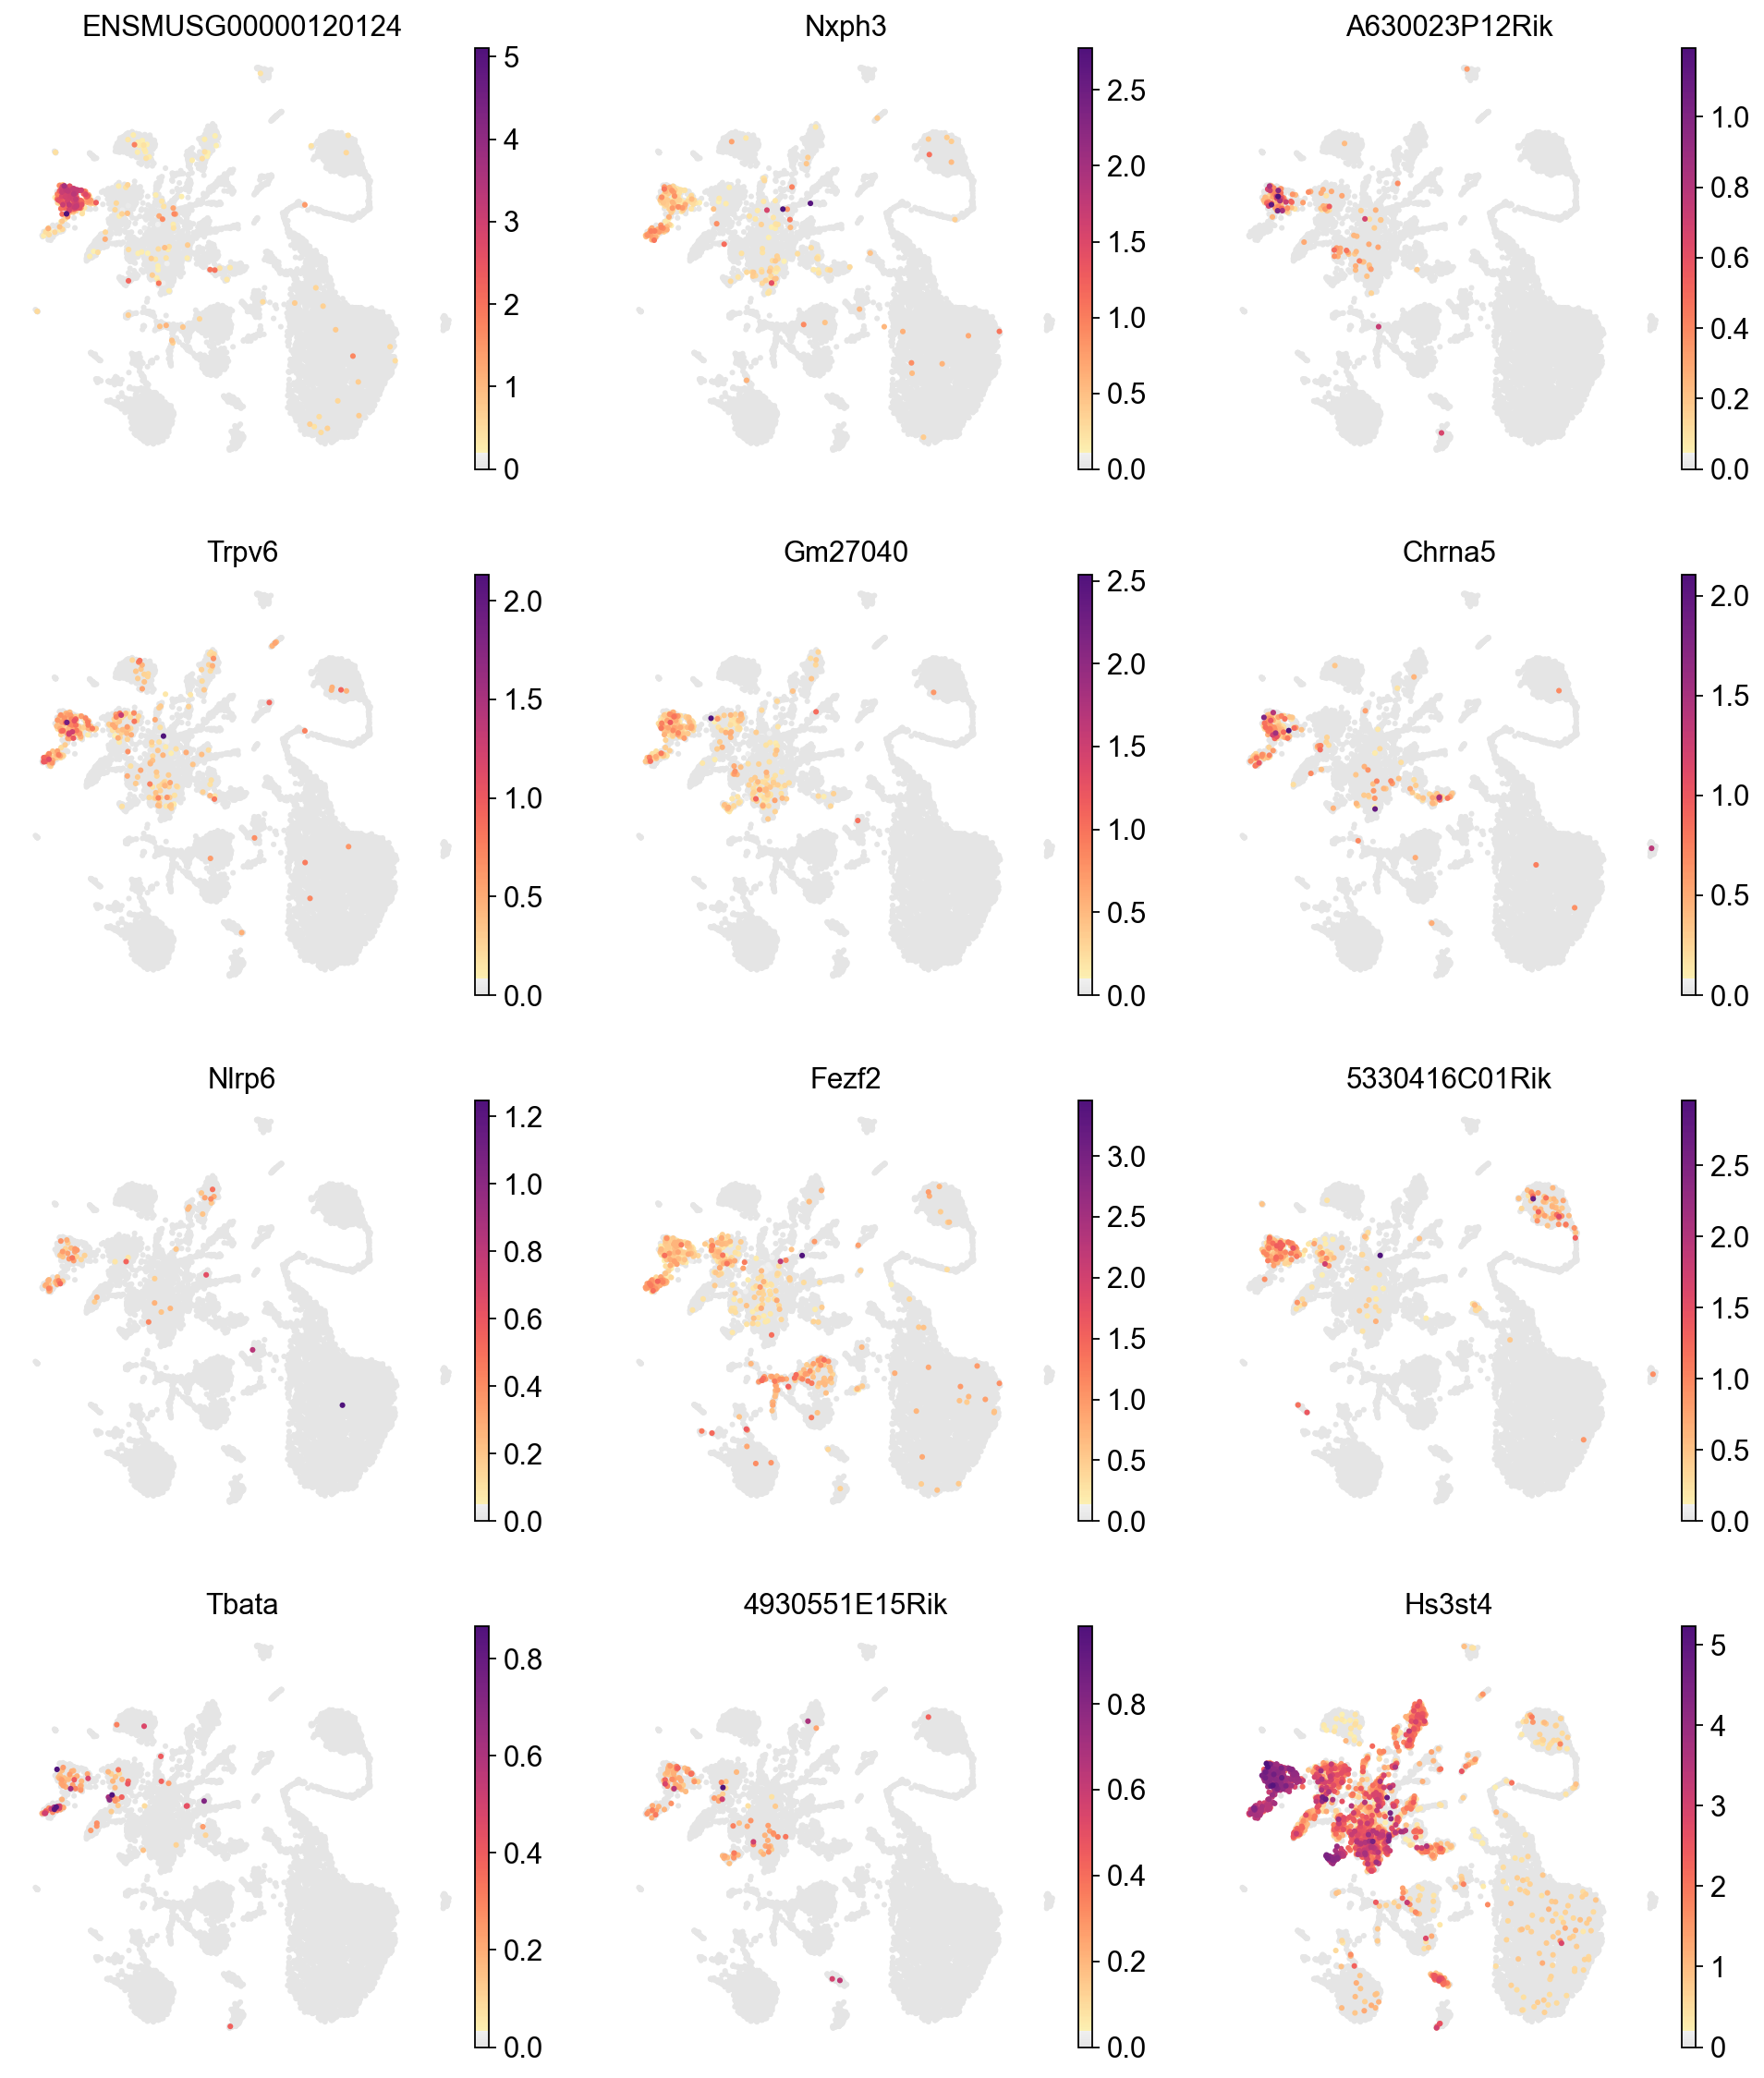

In [33]:
sc.pl.umap(adata,
           color=marker_gene[cluster_check][:12],
           palette=piaso.pl.color.d_color1,
           cmap=piaso.pl.color.c_color1,
           layer='log1p',
           legend_fontsize=12,
           legend_fontoutline=2,
           legend_loc='on data',
           ncols=3,
           size=30,
           frameon=False)

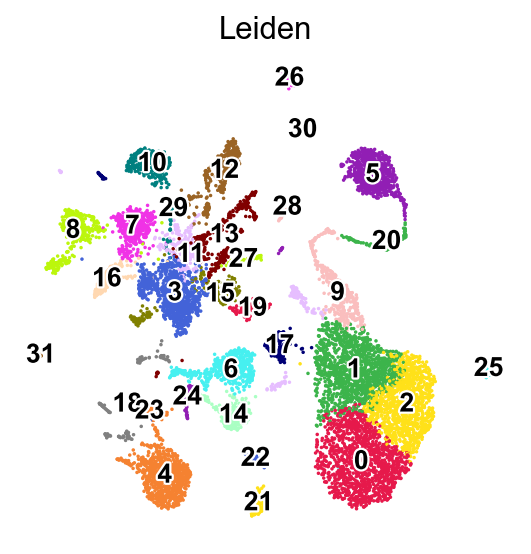

In [34]:
sc.pl.umap(adata,
           color=['Leiden'],
           palette=piaso.pl.color.d_color1,
           cmap=piaso.pl.color.c_color1,
           legend_fontsize=12,
           legend_fontoutline=2,
           legend_loc='on data',
           ncols=1,
           size=10,
           frameon=False)

This pipeline is still in development. The next steps include using a reference dataset to annotate cell types with PIASO's predictCellTypesByGDR, followed by multiple iterations of low-quality cluster removal and re-clustering until well-defined clusters are obtained.